In [1]:
import pandas as pd

In [2]:
surveys_df = pd.read_csv('surveys.csv')
surveys_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35549 entries, 0 to 35548
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   record_id        35549 non-null  int64  
 1   month            35549 non-null  int64  
 2   day              35549 non-null  int64  
 3   year             35549 non-null  int64  
 4   plot_id          35549 non-null  int64  
 5   species_id       34786 non-null  object 
 6   sex              33038 non-null  object 
 7   hindfoot_length  31438 non-null  float64
 8   weight           32283 non-null  float64
dtypes: float64(2), int64(5), object(2)
memory usage: 2.4+ MB


In [8]:
surveys_df[(surveys_df['year'] > 1990) & \
           (surveys_df['weight'] > 40)][['plot_id',
                                         'species_id',
                                         'sex',
                                         'weight']].sort_values('weight', ascending=False).head(5)

,plot_id,species_id,sex,weight
33048,12,NL,M,280.0
30174,2,NL,M,265.0
31861,2,NL,F,252.0
35211,2,NL,M,248.0
27761,12,NL,F,238.0


Now let's do the same thing with Polars...

In [9]:
import polars as pl

In [13]:
surveys_polar = pl.scan_csv('surveys.csv')
surveys_polar.schema

{'record_id': Int64,
 'month': Int64,
 'day': Int64,
 'year': Int64,
 'plot_id': Int64,
 'species_id': Utf8,
 'sex': Utf8,
 'hindfoot_length': Int64,
 'weight': Int64}

In [14]:
surveys_polar.head()

In [15]:
surveys_polar.head().collect()

record_id,month,day,year,plot_id,species_id,sex,hindfoot_length,weight
i64,i64,i64,i64,i64,str,str,i64,i64
1,7,16,1977,2,"""NL""","""M""",32,null
2,7,16,1977,3,"""NL""","""M""",33,null
3,7,16,1977,2,"""DM""","""F""",37,null
4,7,16,1977,7,"""DM""","""M""",36,null
5,7,16,1977,3,"""DM""","""M""",35,null


In [19]:
q = (surveys_polar
     .filter((pl.col('year') > 2000) & (pl.col('weight') > 40))
     .select('plot_id','species_id','sex','weight')
     .sort('weight', descending=True)
    )

In [20]:
q.explain()

'SORT BY [col("weight")]\n  FAST_PROJECT: [plot_id, species_id, sex, weight]\n\n      CSV SCAN surveys.csv\n      PROJECT 5/9 COLUMNS\n      SELECTION: [([(col("year")) > (2000)]) & ([(col("weight")) > (40)])]'

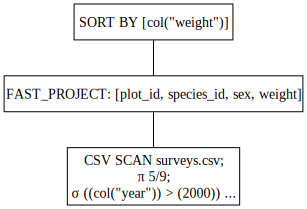

In [21]:
q.show_graph()

In [22]:
q.collect().head()

plot_id,species_id,sex,weight
i64,str,str,i64
12,"""NL""","""M""",280
2,"""NL""","""F""",252
2,"""NL""","""M""",248
2,"""NL""","""M""",238
1,"""NL""","""M""",231


In [23]:
subset_df = q.collect().to_pandas()
subset_df.head()

,plot_id,species_id,sex,weight
0,12,NL,M,280
1,2,NL,F,252
2,2,NL,M,248
3,2,NL,M,238
4,1,NL,M,231


Ok, now let's try to same thing with duckdb

In [24]:
import duckdb

In [25]:
duckdb.sql("""SELECT plot_id, species_id, sex, weight
              FROM 'surveys.csv' """)

┌─────────┬────────────┬─────────┬────────┐
│ plot_id │ species_id │   sex   │ weight │
│  int64  │  varchar   │ varchar │ int64  │
├─────────┼────────────┼─────────┼────────┤
│       2 │ NL         │ M       │   NULL │
│       3 │ NL         │ M       │   NULL │
│       2 │ DM         │ F       │   NULL │
│       7 │ DM         │ M       │   NULL │
│       3 │ DM         │ M       │   NULL │
│       1 │ PF         │ M       │   NULL │
│       2 │ PE         │ F       │   NULL │
│       1 │ DM         │ M       │   NULL │
│       1 │ DM         │ F       │   NULL │
│       6 │ PF         │ F       │   NULL │
│       · │ ·          │ ·       │     ·  │
│       · │ ·          │ ·       │     ·  │
│       · │ ·          │ ·       │     ·  │
│       3 │ NL         │ F       │    141 │
│       1 │ DM         │ F       │     36 │
│       8 │ DO         │ M       │     45 │
│       4 │ DM         │ F       │     33 │
│       5 │ OL         │ M       │   NULL │
│       8 │ DS         │ M      

In [29]:
duck_subset = duckdb.sql("""SELECT plot_id, species_id, sex, weight
                            FROM 'surveys.csv' 
                            WHERE year > 2000 AND weight > 40
                            ORDER BY weight DESC""").df()
duck_subset.head()

,plot_id,species_id,sex,weight
0,12,NL,M,280
1,2,NL,F,252
2,2,NL,M,248
3,2,NL,M,238
4,1,NL,M,231


In [30]:
from pyarrow import csv, parquet

In [32]:
csv_format = csv.read_csv('surveys.csv')
parquet.write_table(csv_format, 'surveys.parquet')

In [33]:
!ls -alh surveys*

-rw-r--r-- 1 triznam 1049089 998K May 31 11:12 surveys.csv
-rw-r--r-- 1 triznam 1049089 333K May 31 11:44 surveys.parquet
